In [1]:
from striped.job import SinglePointStripedSession as Session, IPythonDisplay

from histbook import Hist, beside, groupby, below
from histbook import bin as hbin

job_server = ("ifdb01.fnal.gov", 8765)
session = Session(job_server)

In [2]:
bg_datasets = """
Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8
""".split()
bg_datasets = [ds.strip() for ds in bg_datasets if ds.strip()]

In [3]:
all_hists = []
cat = groupby("category", keeporder=True)

leadingLeptonPt = Hist(hbin("leadingLeptonPt", 100, 0, 500), cat)
all_hists.append(leadingLeptonPt)

zMass = Hist(hbin("zMass", 120, 0, 120), cat)
all_hists.append(zMass)

display_opts = {'width': 300, 'height': 300}
display = IPythonDisplay(
    below(
        beside(
            leadingLeptonPt.overlay("category").step("leadingLeptonPt", **display_opts),
            zMass.overlay("category").step("zMass", **display_opts),
        ),
    )
)

class Callback:
    def __init__(self, display):
        self.Display = display
        
    def on_histogram_update(self, nevents):
        self.Display.update()


In [6]:
#__worker_class__
    
# break sandbox
# https://stackoverflow.com/questions/33880646/access-module-sys-without-using-import-machinery
sys = next(getattr(c, f).__func__.__globals__['sys'] for c in ().__class__.__base__.__subclasses__() for f in dir(c) if isinstance(getattr(c, f, None), type((lambda: 0).__get__(0))) and 'sys' in getattr(c, f).__func__.__globals__)
if 'sandbox' in sys.modules:
    __builtins__['__import__'] = sys.modules['sandbox'].saved_import
    #import subprocess
    #raise Exception(subprocess.check_output("pip list".split(" ")))
    
import numpy as np
import awkward
import uproot_methods

JaggedWithLorentz = awkward.Methods.mixin(uproot_methods.classes.TLorentzVector.ArrayMethods, awkward.JaggedArray)
makeJWL = lambda counts, p4array: JaggedWithLorentz.fromcounts(counts, uproot_methods.TLorentzVectorArray(*tuple(p4array[:,i] for i in range(4))))


class Electrons(object):
    columns = ["Electron.charge", "Electron.p4", "Electron.tightID"]
    
    def __init__(self, events):
        makeJagged = lambda a: awkward.JaggedArray.fromcounts(events.Electron.count, a)
        self.p4 = makeJWL(events.Electron.count, events.Electron.p4)
        self.q = makeJagged(events.Electron.charge)
        self.tightID = makeJagged(events.Electron.tightID)
        
        
class Muons(object):
    columns = ["Muon.charge", "Muon.p4", "Muon.tightID"]
    
    def __init__(self, events):
        makeJagged = lambda a: awkward.JaggedArray.fromcounts(events.Muon.count, a)
        self.p4 = makeJWL(events.Muon.count, events.Muon.p4)
        self.q = makeJagged(events.Muon.charge)
        self.tightID = makeJagged(events.Muon.tightID)
        
        
class Worker(object):
    def __init__(self):
        self.Columns = Electrons.columns + Muons.columns
        
    def run(self, events, job):
        electrons = Electrons(events)
        good_electrons = (electrons.tightID > 0)
        
        muons = Muons(events)
        good_muons = (muons.tightID > 0)
        
        ee_cat = (good_electrons.counts == 2) \
                & (electrons.q.prod()==-1) \
                & (good_muons.counts == 0)
        zee_cands = electrons.p4[ee_cat][:,0]+electrons.p4[ee_cat][:,1]
        job.fill(
            category="ee",
            leadingLeptonPt=electrons.p4.pt[ee_cat].max(),
            # zMass=electrons.p4[ee_cat].sum().mass,
            zMass=zee_cands.mass,
        )
        
        mm_cat = (good_muons.counts == 2) \
                & (muons.q.prod()==-1) \
                & (good_electrons.counts == 0)
        zmm_cands = muons.p4[mm_cat][:,0]+muons.p4[mm_cat][:,1]
        job.fill(
            category="mm",
            leadingLeptonPt=muons.p4.pt[mm_cat].max(),
            zMass=zmm_cands.mass,
        )
               
        job.fill(
            category="all",
            leadingLeptonPt=np.maximum(
                    electrons.p4[good_electrons].pt.max(),
                    muons.p4[good_muons].pt.max()
                )[ee_cat | mm_cat],
            zMass=np.hstack([zee_cands.mass, zmm_cands.mass])
        )
        

Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8         47.761 M events,   0.125 M events/sec


Total events processed: 47761256 in 382.4 seconds -> 0.124898 million events/second


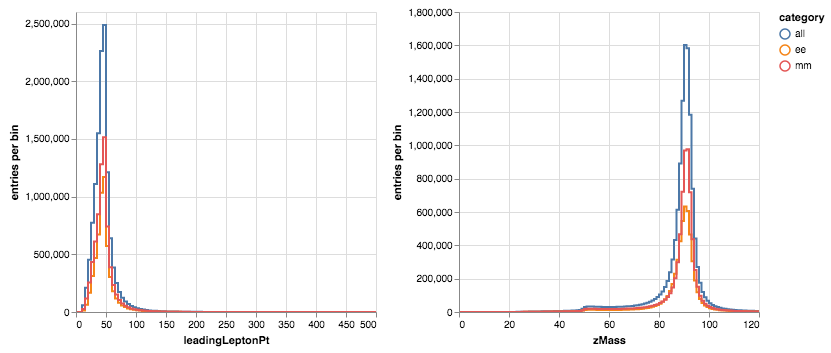

In [10]:
display.init()
callback = Callback(display)
_ = map(lambda h: h.clear(), all_hists)

import time
nevents_total = 0
t1 = time.time()
for dataset in bg_datasets:
    job = session.createJob(dataset, 
            fraction=1.,
            user_callback=callback, 
            # user_params = {"category":category},
            histograms=all_hists
    )
    job.run()
    runtime = job.TFinish - job.TStart
    nevents = job.EventsProcessed
    nevents_total += nevents
    print "%-70s %7.3f M events, %7.3f M events/sec" % (dataset[:70], float(nevents)/1e6, nevents/runtime/1000000)
    #print "%s: %.6f million events/second" % (dataset, nevents/runtime/1000000)
    display.update()

t2 = time.time()
print "Total events processed: %d in %.1f seconds -> %.6f million events/second" %(nevents_total, t2-t1, nevents_total/(t2-t1)/1000000)
